In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend, regularizers
import matplotlib.pyplot as plt
import pickle, cv2
import os

In [2]:
data = np.load("all_data.npz")
X = data["images"]
Y = data["labels"]
names = data["names"]

In [3]:
np.random.seed(20150828)
randomized_order = np.random.permutation(X.shape[0])

train_len = int(X.shape[0] * 0.8)
X_train, X_test = X[randomized_order[:train_len],:], X[randomized_order[train_len:],:]
Y_train, Y_test = Y[randomized_order[:train_len],], Y[randomized_order[train_len:],]
names_train, names_test = names[randomized_order[:train_len],], names[randomized_order[train_len:],]



In [4]:
resnet = ResNet50(include_top=False, input_shape=(224,224,3), weights="imagenet", pooling='avg')
model = Sequential()
model.add(resnet)
model.add(Dropout(0.5))
model.add(Dense(1))
model.layers[0].trainable = False

sgd = SGD(learning_rate=0.001, decay=1e-6, momentum=0.9, nesterov=True)
adam = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999)
model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mean_squared_error'])

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
checkPoint = ModelCheckpoint(filepath='model-ms-resnet-no-adj.h5', verbose=1, save_best_only=True)



Metal device set to: Apple M1 Max


2022-08-02 21:11:34.039967: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-02 21:11:34.040204: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
# model.load_weights('../models/model-ms-resnet-no-adj.h5')

In [5]:
history = model.fit(x=X_train, y=Y_train, batch_size=32, callbacks=[earlyStopping, checkPoint], epochs=100, verbose=1, validation_split=0.2)

Epoch 1/100


2022-08-02 21:11:42.445263: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-02 21:11:43.674661: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


110/110 [==============================] - ETA: 0s - loss: 0.7623 - mean_squared_error: 0.7623

2022-08-02 21:11:55.244065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.34226, saving model to model-ms-resnet-no-adj.h5
110/110 [==============================] - 16s 125ms/step - loss: 0.7623 - mean_squared_error: 0.7623 - val_loss: 0.3423 - val_mean_squared_error: 0.3423
Epoch 2/100
110/110 [==============================] - ETA: 0s - loss: 0.3716 - mean_squared_error: 0.3716
Epoch 2: val_loss did not improve from 0.34226
110/110 [==============================] - 10s 95ms/step - loss: 0.3716 - mean_squared_error: 0.3716 - val_loss: 0.3661 - val_mean_squared_error: 0.3661
Epoch 3/100
110/110 [==============================] - ETA: 0s - loss: 0.3647 - mean_squared_error: 0.3647
Epoch 3: val_loss did not improve from 0.34226
110/110 [==============================] - 12s 105ms/step - loss: 0.3647 - mean_squared_error: 0.3647 - val_loss: 0.5377 - val_mean_squared_error: 0.5377
Epoch 4/100
110/110 [==============================] - ETA: 0s - loss: 0.4242 - mean_squared_error: 0.4242
Epoch 4: val_loss did not improve

Epoch 27/100
110/110 [==============================] - ETA: 0s - loss: 0.3266 - mean_squared_error: 0.3266
Epoch 27: val_loss did not improve from 0.25164
110/110 [==============================] - 12s 111ms/step - loss: 0.3266 - mean_squared_error: 0.3266 - val_loss: 0.4259 - val_mean_squared_error: 0.4259
Epoch 28/100
110/110 [==============================] - ETA: 0s - loss: 0.3095 - mean_squared_error: 0.3095
Epoch 28: val_loss did not improve from 0.25164
110/110 [==============================] - 12s 112ms/step - loss: 0.3095 - mean_squared_error: 0.3095 - val_loss: 0.2641 - val_mean_squared_error: 0.2641
Epoch 29/100
110/110 [==============================] - ETA: 0s - loss: 0.3231 - mean_squared_error: 0.3231
Epoch 29: val_loss did not improve from 0.25164
110/110 [==============================] - 12s 106ms/step - loss: 0.3231 - mean_squared_error: 0.3231 - val_loss: 0.4353 - val_mean_squared_error: 0.4353


In [8]:
# model.save_weights('../models/model-ms-resnet-no-adj.h5')


In [7]:
model.layers[0].trainable = True

adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mean_squared_error', 'mae'])
# model.load_weights('model-ms-resnet.h5', by_name=True)
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')
checkPoint = ModelCheckpoint(filepath='model-ms-all-resnet-no-adj.h5', verbose=1, save_best_only=True)

history = model.fit(x=X_train, y=Y_train, batch_size=32, callbacks=[earlyStopping, checkPoint], epochs=100, verbose=1, validation_split=0.2)


Epoch 1/100


2022-08-02 21:29:27.118032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


110/110 [==============================] - ETA: 0s - loss: 92.8040 - mean_squared_error: 92.8040 - mae: 4.4638

2022-08-02 21:30:00.443020: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 1.35487, saving model to model-ms-all-resnet-no-adj.h5
110/110 [==============================] - 40s 314ms/step - loss: 92.8040 - mean_squared_error: 92.8040 - mae: 4.4638 - val_loss: 1.3549 - val_mean_squared_error: 1.3549 - val_mae: 0.9643
Epoch 2/100
110/110 [==============================] - ETA: 0s - loss: 0.9591 - mean_squared_error: 0.9591 - mae: 0.7657
Epoch 2: val_loss did not improve from 1.35487
110/110 [==============================] - 30s 276ms/step - loss: 0.9591 - mean_squared_error: 0.9591 - mae: 0.7657 - val_loss: 6.2543 - val_mean_squared_error: 6.2543 - val_mae: 2.4051
Epoch 3/100
110/110 [==============================] - ETA: 0s - loss: 0.8586 - mean_squared_error: 0.8586 - mae: 0.7338
Epoch 3: val_loss did not improve from 1.35487
110/110 [==============================] - 30s 276ms/step - loss: 0.8586 - mean_squared_error: 0.8586 - mae: 0.7338 - val_loss: 6.1831 - val_mean_squared_error: 6.1831 - val_mae: 2.3870
Epoch 4/1

Epoch 24/100
110/110 [==============================] - ETA: 0s - loss: 0.1237 - mean_squared_error: 0.1237 - mae: 0.2784
Epoch 24: val_loss did not improve from 0.27783
110/110 [==============================] - 37s 334ms/step - loss: 0.1237 - mean_squared_error: 0.1237 - mae: 0.2784 - val_loss: 3.9852 - val_mean_squared_error: 3.9852 - val_mae: 1.9361
Epoch 25/100
110/110 [==============================] - ETA: 0s - loss: 0.0959 - mean_squared_error: 0.0959 - mae: 0.2462
Epoch 25: val_loss did not improve from 0.27783
110/110 [==============================] - 37s 339ms/step - loss: 0.0959 - mean_squared_error: 0.0959 - mae: 0.2462 - val_loss: 1.3968 - val_mean_squared_error: 1.3968 - val_mae: 1.1017
Epoch 26/100
110/110 [==============================] - ETA: 0s - loss: 0.1386 - mean_squared_error: 0.1386 - mae: 0.2956
Epoch 26: val_loss did not improve from 0.27783
110/110 [==============================] - 36s 330ms/step - loss: 0.1386 - mean_squared_error: 0.1386 - mae: 0.2956 - 

In [10]:
model.save_weights('../models/model-ms-all-resnet-no-adj.h5')


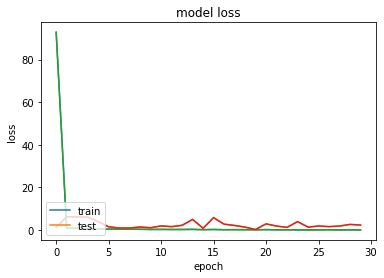

In [8]:
fig = plt.figure()
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower left')


In [10]:
model.load_weights('../models/model-ms-all-resnet-no-adj.h5')

In [11]:
model.evaluate(X_test, Y_test)

35/35 [==============================] - 3s 72ms/step - loss: 0.2748 - mean_squared_error: 0.2748 - mae: 0.4124


[0.274797260761261, 0.274797260761261, 0.4124491810798645]

In [12]:
Y_pred = model.predict(X_test)

2022-08-02 22:06:54.901968: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


35/35 [==============================] - 4s 79ms/step


In [13]:
np.corrcoef(Y_test, Y_pred[:,0])[0,1]

0.8021815355244505

In [14]:
((Y_test - Y_pred[:,0])**2).mean()

0.2747972656159371

In [15]:
np.sqrt(((Y_test - Y_pred[:,0])**2).mean())

0.524211088795284

In [16]:
np.abs(Y_test - Y_pred[:,0]).mean()

0.4124492295756392

In [17]:
pd.DataFrame({"label": Y_test, "prediction": Y_pred.T[0]}).to_csv("../results/test-predict-no-adj.csv")

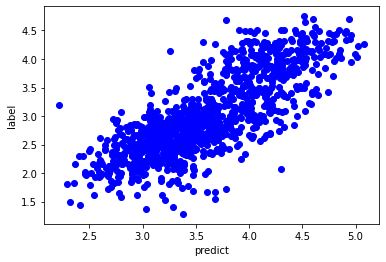

In [19]:
plt.plot(Y_pred[:,0], Y_test, "bo")
plt.xlabel("predict")
plt.ylabel("label")
plt.show()